In [5]:
%matplotlib inline
import os
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt

In [4]:
from FCN import get_FCN
from data_reader import load_data_voc

batch_size, crop_size = 16, (320, 480)
train_iter, test_iter = load_data_voc(batch_size, crop_size)

net = get_FCN(num_classes=21)


read 1114 examples
read 1078 examples


KeyboardInterrupt: 

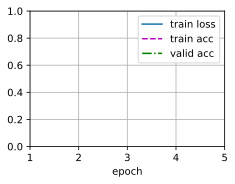

In [6]:
def loss(inputs, targets):
    from torch.nn import functional as F
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

from model_trainer import train_model

num_epochs, lr, wd = 5, 0.001, 1e-3
device =  'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

train_model(net, train_iter, test_iter, loss, trainer, num_epochs, device)
